In [13]:
from IPython.core.pylabtools import figsize

from misc.misc import detect_gaussian_spots_subpixel
%matplotlib inline 
import os 
import datetime
import numpy as np
import matplotlib.pyplot as plt
import glob 
from pianoq.simulations.mplc_sim.mplc_sim_result import MPLCMasks
from pianoq.lab.mplc.phase_finder_result import PhaseFinderResult
from pianoq_results.scan_result import ScanResult
from pianoq.lab.mplc.discrete_scan_result import DiscreetScanResult
dir_path = r'G:\My Drive\Projects\MPLC\results\lab\2024_10_09_fixing_phases_different_Us'

# TODO
- check if the spread in the x locations of the spots in different Us happens already in the WFM. 

# Experiment goals 

When calculating transformations with WFM, the final phases, which in simulation give good restuls, don't quite work in the lab. Rather, there is still some need for optimization on the phases of the input spots. 

It is not clear where these come from. maybe: a) WFM doesn't do good enough job due to cross-talk etc. so we have WFM+phases that give good transformation. b) something in the setup, some quadratic phase, some SLM non-flatness, etc. 

To check this, we perform a few random measurements, that are supposed to result with strong diagonal correlations. (Specifically, we take the first 5 random Haars from Ohads 800, and do ```[[U, 0], [0, U.conj()]] ``` , which fomr Klyshko could be understood will result in a strong diagonal, because it will be ```U*U^dag```.

We perform WFM on the 5 different transformations, and first look where the 5 spots occur, which is another something to understand: do we need each time to search for the spots with the single counts, or is it enough to do it for a single transformation? 

Here are the single counts scan results for the different 5 Us: 

 

# Spot locations

In [14]:
sig_scans = []
idl_scans = []
for U_no in range(5):
    idl_path = glob.glob(rf'{dir_path}\U{U_no}U*idler_res_1.scan')[0]
    idl_sc = ScanResult()
    idl_sc.loadfrom(idl_path)
    idl_scans.append(idl_sc)
    
    sig_path = glob.glob(rf'{dir_path}\U{U_no}U*signal_res_1.scan')[0]
    sig_sc = ScanResult()
    sig_sc.loadfrom(sig_path)
    sig_scans.append(sig_sc)

C:\Users\owner\AppData\Local\Temp\ipykernel_6140\1198101479.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


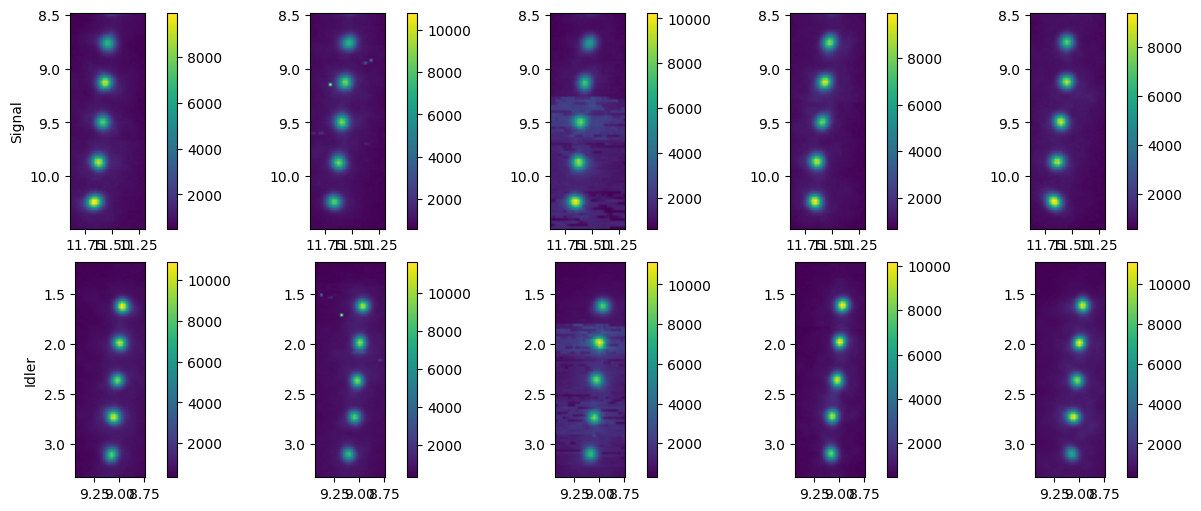

In [15]:
from pianoq.misc.mplt import my_mesh
fig, axes = plt.subplots(2, 5, constrained_layout=True, figsize=(12, 5))
for i in range(5):
    my_mesh(sig_scans[i].X, sig_scans[i].Y, sig_scans[i].single2s, axes[0, i])
    axes[0, i].invert_xaxis()
    my_mesh(idl_scans[i].X, idl_scans[i].Y, idl_scans[i].single1s, axes[1, i])
    axes[1, i].invert_xaxis()
axes[0, 0].set_ylabel('Signal')
_ = axes[1, 0].set_ylabel('Idler')
fig.show()

I am not sure what is the weird noise in the middle one, but it is not so interesting. 

Notably, the idler spots don't look all at the exact same place. (especially the 5th scan). Here are the manually clicked locations for signal and idler spots on top of each other for the different 5 Us:

In [16]:
idl_locs = []
sig_locs = []
for U_no in range(5):
    idl_path = glob.glob(rf'{dir_path}\U{U_no}U*idl.locs')[0]
    il = np.load(idl_path)['locs']
    idl_locs.append(il)
    
    sig_path = glob.glob(rf'{dir_path}\U{U_no}U*sig.locs')[0]
    sl = np.load(sig_path)['locs']
    sig_locs.append(sl)

sig_locs = np.array(sig_locs)
idl_locs = np.array(idl_locs)

C:\Users\owner\AppData\Local\Temp\ipykernel_6140\595830173.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


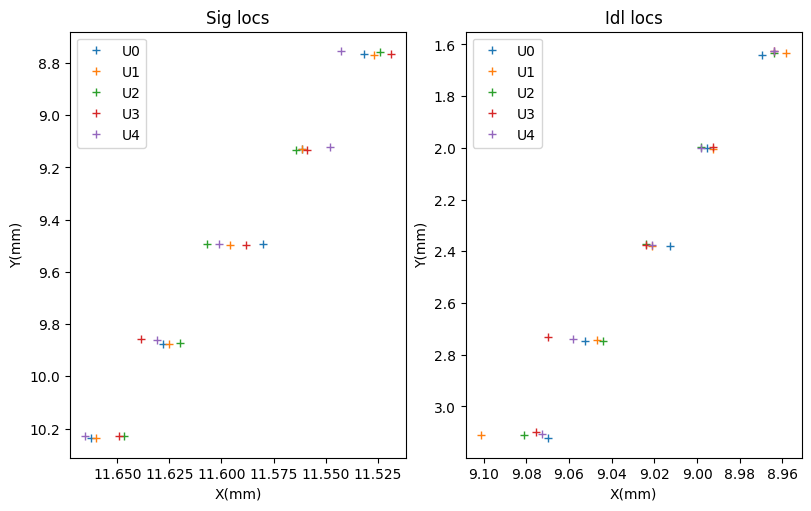

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
for U_no in range(5):
    axes[0].plot(sig_locs[U_no, :, 0], sig_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')
    axes[1].plot(idl_locs[U_no, :, 0], idl_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')

axes[0].set_title('Sig locs')
axes[1].set_title('Idl locs')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('X(mm)')
axes[0].set_ylabel('Y(mm)')
axes[1].set_ylabel('Y(mm)')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[1].invert_xaxis()
axes[1].invert_yaxis()
_ = axes[1].set_xlabel('X(mm)')
fig.show()

It seems that there is a ~20um spread in the both the X and Y axes (Y is harder to see without zooming in). I am pretty sure this happens already in the WFM, and is not related to the experimental system. This may be a possible explanation for the difference between simulation and experiment that Ohad was looking for? If the fiber is not centered on the spot, it will get lower counts (20um for 100um fibers is not much, but also not negligible.). Note though that these where clicked by hand, so also mouse inaccuracy could cause some of this... Should probably automate this with some find_peaks and check again. 

So I (=Claude.ai) wrote some code to automatically find the middles, and here are his results: 

C:\Users\owner\AppData\Local\Temp\ipykernel_6140\579501426.py:21: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


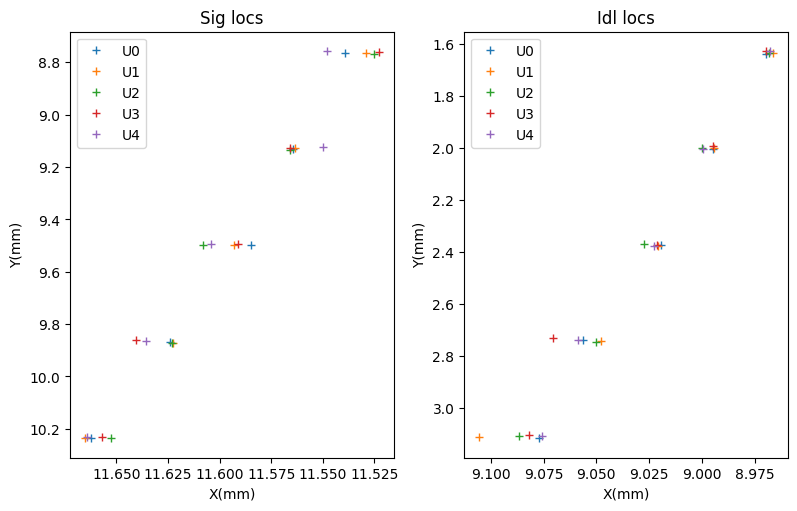

In [18]:
from pianoq.misc.misc import detect_gaussian_spots_subpixel
fig, axes = plt.subplots(1, 2, figsize=(8, 5), constrained_layout=True)
for U_no in range(5):
    s_locs = detect_gaussian_spots_subpixel(sig_scans[U_no].single2s, sig_scans[U_no].X, sig_scans[U_no].Y[::-1])
    i_locs = detect_gaussian_spots_subpixel(idl_scans[U_no].single1s, idl_scans[U_no].X, idl_scans[U_no].Y[::-1])
    axes[0].plot(s_locs[:, 0], s_locs[:, 1], marker='+', linestyle='none', label=f'U{U_no}')
    axes[1].plot(i_locs[:, 0], i_locs[:, 1], marker='+', linestyle='none', label=f'U{U_no}')

axes[0].set_title('Sig locs')
axes[1].set_title('Idl locs')
axes[0].legend()
axes[1].legend()
axes[0].set_xlabel('X(mm)')
axes[0].set_ylabel('Y(mm)')
axes[1].set_ylabel('Y(mm)')
axes[0].invert_xaxis()
axes[0].invert_yaxis()
axes[1].invert_xaxis()
axes[1].invert_yaxis()
_ = axes[1].set_xlabel('X(mm)')
fig.show()

OK, so lets see it all together:

C:\Users\owner\AppData\Local\Temp\ipykernel_6140\3817400286.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


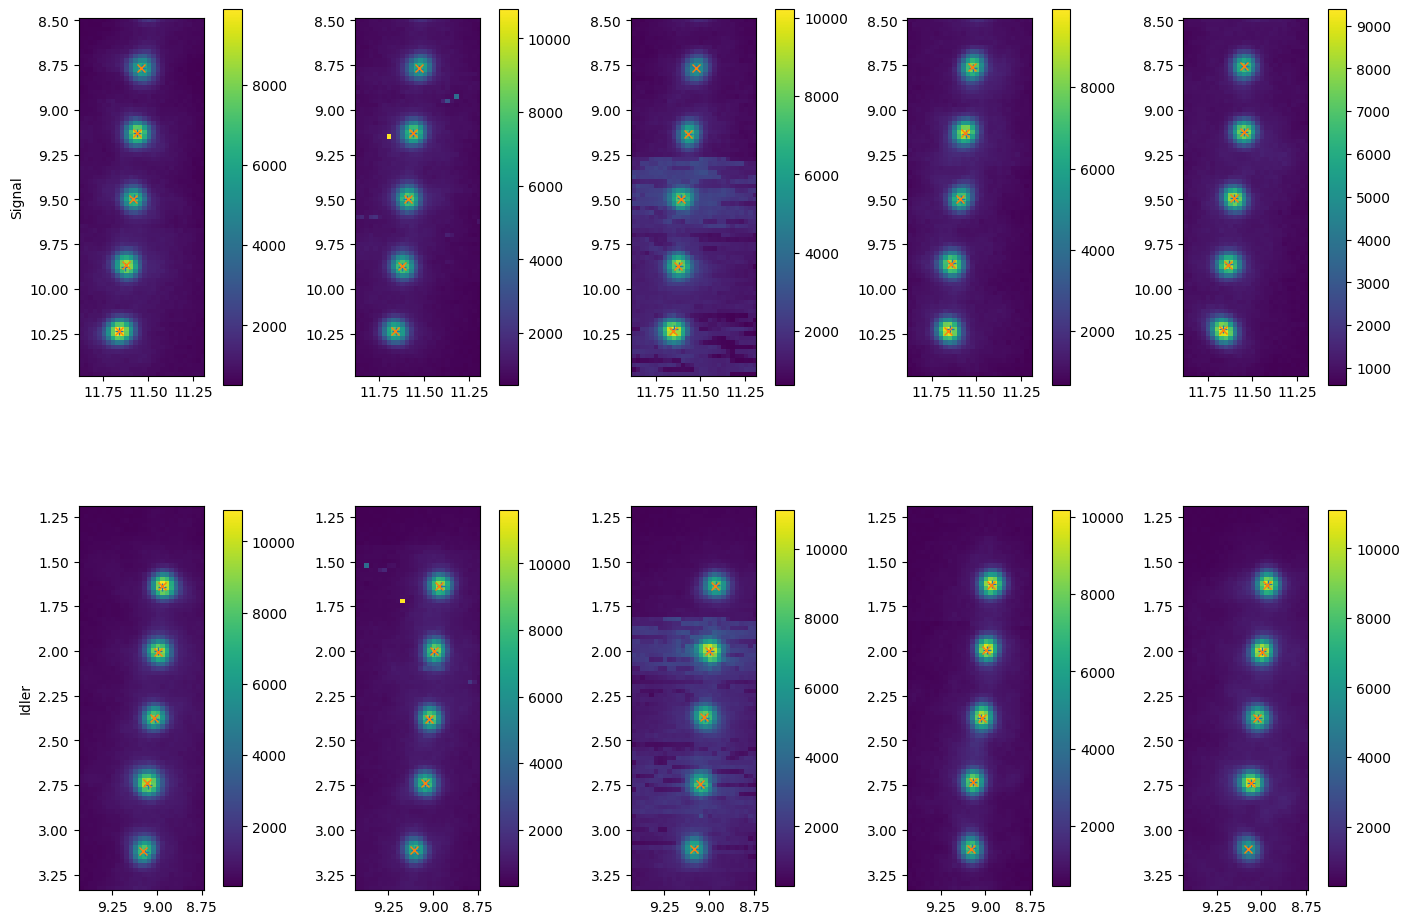

In [19]:
from pianoq.misc.mplt import my_mesh
fig, axes = plt.subplots(2, 5, constrained_layout=True, figsize=(14, 10))
for U_no in range(5):
    my_mesh(sig_scans[U_no].X, sig_scans[U_no].Y, sig_scans[U_no].single2s, axes[0, U_no])
    axes[0, U_no].invert_xaxis()
    my_mesh(idl_scans[U_no].X, idl_scans[U_no].Y, idl_scans[U_no].single1s, axes[1, U_no])
    axes[1, U_no].invert_xaxis()
    axes[0, U_no].plot(sig_locs[U_no, :, 0], sig_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')
    axes[1, U_no].plot(idl_locs[U_no, :, 0], idl_locs[U_no, :, 1], marker='+', linestyle='none', label=f'U{U_no}')
    
    s_locs = detect_gaussian_spots_subpixel(sig_scans[U_no].single2s, sig_scans[U_no].X, sig_scans[U_no].Y[::-1])
    i_locs = detect_gaussian_spots_subpixel(idl_scans[U_no].single1s, idl_scans[U_no].X, idl_scans[U_no].Y[::-1])
    axes[0, U_no].plot(s_locs[:, 0], s_locs[:, 1], marker='x', linestyle='none', label=f'U{U_no}')
    axes[1, U_no].plot(i_locs[:, 0], i_locs[:, 1], marker='x', linestyle='none', label=f'U{U_no}')


axes[0, 0].set_ylabel('Signal')
_ = axes[1, 0].set_ylabel('Idler')
fig.show()

And now more quantitatively, lets calculate the X,Y std of location for the 5 different transformations. 

In [20]:
auto_s_locs = []
auto_i_locs = []
for U_no in range(5):
    s_l = detect_gaussian_spots_subpixel(sig_scans[U_no].single2s, sig_scans[U_no].X, sig_scans[U_no].Y[::-1])
    i_l = detect_gaussian_spots_subpixel(idl_scans[U_no].single1s, idl_scans[U_no].X, idl_scans[U_no].Y[::-1])
    auto_s_locs.append(s_l)
    auto_i_locs.append(i_l)

auto_s_locs = np.array(auto_s_locs)
auto_i_locs = np.array(auto_i_locs)

In [21]:
x_var_sig_manual = sig_locs.std(axis=0).mean(axis=0)[0]
y_var_sig_manual = sig_locs.std(axis=0).mean(axis=0)[1]
x_var_idl_manual = idl_locs.std(axis=0).mean(axis=0)[0]
y_var_idl_manual = idl_locs.std(axis=0).mean(axis=0)[1]
print("Manual spots click:")
print(f'{x_var_sig_manual=:.4f}\n{y_var_sig_manual=:.4f}\n{x_var_idl_manual=:.4f}\n{y_var_idl_manual=:.4f}\n')

x_var_sig_auto = auto_s_locs.std(axis=0).mean(axis=0)[0]
y_var_sig_auto = auto_s_locs.std(axis=0).mean(axis=0)[1]
x_var_idl_auto = auto_i_locs.std(axis=0).mean(axis=0)[0]
y_var_idl_auto = auto_i_locs.std(axis=0).mean(axis=0)[1]
print("Auto spots finder:")
print(f'{x_var_sig_auto=:.4f}\n{y_var_sig_auto=:.4f}\n{x_var_idl_auto=:.4f}\n{y_var_idl_auto=:.4f}')

Manual spots click:
x_var_sig_manual=0.0073
y_var_sig_manual=0.0049
x_var_idl_manual=0.0062
y_var_idl_manual=0.0051

Auto spots finder:
x_var_sig_auto=0.0073
y_var_sig_auto=0.0028
x_var_idl_auto=0.0051
y_var_idl_auto=0.0040


And it seems that everything is rather reasonable. My and the automatic Xs look similar, and in both cases we have a standard deviation of 5-7um in X and in Y.

We now also look at the original WFM output, to see if the spot location variation happens already in the WFM, or rather only in the actual experiment. 

# Phases 

Show the different phases we found etc. Maybe also some sum projection.  

# Correlations 

Talk about bad correlations. Probably stupid bug. Still correlations not perfect, but not worrying or de-buging too much, since I don't really care that much. 
Now it's just about time to look whether I actually got good correlations! 